# Introduction to Raster Data in Python and QGIS
---

**Objectives:**

By the end of this exercise, you should be able to:

* explain the difference between raster and vector data
* open raster data using a GeoTiff in Python and QGIS
* determine the metadata - including CRS, resolution, and extent - of a raster image in Python and QGIS
* describe the difference between continuous and classified raster data and provide an example of each
* visualize a raster image and the distribution of pixel values in Python and QGIS
* calculate the minimum and maximum pixel values
* plot a raster and vector layer on one map
* clip a raster image using a vector layer
* summarize raster values at specific points
---

This exercise builds on our introduction to spatial data and analysis in Python from `exercise1`. In this exercise, we are focusing on raster data, which are gridded data, and have an array of uses including photograps and satellite imagery. These data are stored as a grid of values, where each value on the grid is a pixel on a map or in an image. 

<p align="center">
    <img src='imgs/intro_raster.png' width='500' /> 
    <figcaption>Fig.1 - An example of a raster (gridded data), its values, and how they can be visualized to represent the Earth's surface. Source: Collin Williams, NEON.
</p>

For spatial data, rasters are spatially referenced and each pixel represents an area on the Earth's surface. The area of the Earth's surface that the pixel represents is the **spatial resolution** of the raster. For example, a 30 meter resolution raster means that each pixel represents a 30 m by 30 m area on the Earth.

<p align="center">
    <img src='imgs/raster_resolutions.png' width='700' /> 
    <figcaption>Fig.2 - An example of a raster different raster resolutions (the area covered by each pixel). Source: Collin Williams, NEON.
</p>

Source: Leah Wasser, Chris Holdgraf, Martha Morrissey; Earth Lab.

We will practice reading and visualizing raster data in this exercise.

First, we will need to import our Python packages. We are using many of the same packages as our previous exercise with vector data; however, the `rasterio` and `rioxarray` packages are specifically for raster data. We can use them to read, analyze, and visualize raster data. We can also visualize raster data using matplotlib, as you will see.

In [1]:
import os
import rasterio as rio
import rioxarray as rxr
import geopandas as gpd
import numpy as np
import pandas as pd
import folium
import matplotlib.pyplot as plt

### Opening a Raster in Python

Next, we will use the `rasterio` and `rioxarray` packages to read in GeoTiffs of land cover and elevation data for North Carolina. The dataset we are using for land cover, the 2019 National Land Cover Database (NLCD), is produced by the U.S. Geological Survey in partnership with other federal agencies and can be found [here](https://www.mrlc.gov/data/nlcd-2019-land-cover-conus). There are currently 6 NLCD products - 1992, 2001, 2006, 2011, 2016, and 2019 - that provide spatially explicit land cover at a 30 meter resoltion across the contiguous U.S. The size of the full CONUS NLCD data for 2019 is ~29 GB. We have clipped these data to the state of North Carolina for our exercise (size ~300 MB).

A GeoTiff is an image file format that contains embedded georeferencing information. This spatial information includes map projection, coordinate reference systems, ellipsoids, and datums. These spatial data are used to describe the actual spatial location for each pixel in the image.

In [2]:
# set raster paths

# NLCD data for lower 48 US
nc_lclu_path = './data/nlcd_2019_land_cover_l48/NLCD_2019_NC.tif'

# SRTM data for North Carolina
nc_dem_path = './data/SRTM_NC/SRTM_NC.tif'

To open a raster using `rasterio`, we usually want to use a `WITH` statement. These statements allow us to read in data and metadata from a raster, or other file type, and then close them properly. If we use a `.open()` function without a `WITH` statement, we *must* remember to use the `.close()` function when we are finished. Otherwise, Pyhton still has the file open and we could make unintended changes or close the file improperly and corrupt it.

To read in the pixel values from the opened raster object, we use the `.read()` function. The number in the parentheses indicates which raster band we want to read, starting with 1. (`rasterio` starts its band indexing at 1 instead of 0.) We will learn more about raster bands in `exercise3`.

Similar to shapefiles read with `geopandas`, we can call specific attribute of the open raster object to get metadata information. Once we are out of the `WITH` statement, we can no longer access these attributes.

In [3]:
# read in raster with rasterio

with rio.open(nc_lclu_path) as src:
    lclu_data = src.read(1) # use 1 because rasters index starting at 1
    
    # get metadata
    lclu_meta = src.meta
    for key in lclu_meta.keys():
        print(f'{key}: {lclu_meta[key]}')
    # save metadata of interest by specifically calling the src attributes
    lclu_crs = src.crs # corrdinate reference system of the raster
    lclu_res = src.res # resolution of the pixels
    lclu_extent = src.bounds # coordinates for the bounding box of the raster
    lclu_bands = src.count # number of bands in the raster
    lclu_transform = src.transform # more spatial information, including pixel resolution and bounds as a specific data type

    lclu_colors = src.colormap(1) # get the colormap for Band 1

    # compare the FOR loop printed information and the direct print
    print(f'\n{src.meta}')

driver: GTiff
dtype: uint8
nodata: None
width: 26158
height: 11613
count: 1
crs: PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
transform: | 30.00, 0.00, 1054155.00|
| 0.00,-30.00, 1690155.00|
| 0.00, 0.00, 1.00|

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 26158, 'height': 11613, 'count': 1, 'crs': CRS.from_wkt('PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORI

What is the `CRS` and spatial extent (`src.bounds`) of this dataset?

In [4]:
print(f'CRS: {lclu_crs}')
print(f'Spatial extent: {lclu_extent}')

CRS: PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Spatial extent: BoundingBox(left=1054155.0, bottom=1341765.0, right=1838895.0, top=1690155.0)


Now, let's look at how the raster data is read by Python, and what it looks like.

In [5]:
print(type(lclu_data))

lclu_data

<class 'numpy.ndarray'>


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

The pixel values of a raster are stored in a matrix format. When we look at the raw data, we can see an array of arrays. Each row represents a horizontal row of pixels in our raster image.

`rioxarray` can also read in raster data. It is a package that expands the `xarray` package and capabilities with the spatial raster reading, processing, and analyzing capabilities of `rasterio`. When you open a raster using `rioxarray`, the pixel data is stored in an `xarray.DataArray` which uses `numpy` arrays and is very efficient. 

In [6]:
# read in raster with rioxarray
# del(lclu_data_rxr)
lclu_data_rxr = rxr.open_rasterio(nc_lclu_path)

lclu_data_rxr

<xarray.DataArray (band: 1, y: 11613, x: 26158)>
[303772854 values with dtype=uint8]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 1.054e+06 1.054e+06 ... 1.839e+06 1.839e+06
  * y            (y) float64 1.69e+06 1.69e+06 1.69e+06 ... 1.342e+06 1.342e+06
    spatial_ref  int32 0
Attributes:
    LAYER_TYPE:           thematic
    OVERVIEWS_ALGORITHM:  IMAGINE Nearest Neighbor Resampling
    scale_factor:         1.0
    add_offset:           0.0
    long_name:            Layer_1

Like with `raterio`, we can look at metadata and spatial data by calling the attributes.

In [7]:
print(f'CRS for {os.path.basename(nc_lclu_path)}: {lclu_data_rxr.rio.crs}')
print(f'Resolution for {os.path.basename(nc_lclu_path)}: {lclu_data_rxr.rio.resolution()}')
print(f'bounds for {os.path.basename(nc_lclu_path)}: {lclu_data_rxr.rio.bounds()}')
print(f'Number of bands for {os.path.basename(nc_lclu_path)}: {lclu_data_rxr.rio.count}')
print(f'Shape for {os.path.basename(nc_lclu_path)}: {lclu_data_rxr.rio.shape}')
print(f'No data values for {os.path.basename(nc_lclu_path)}: {lclu_data_rxr.rio.nodata}')
print(f'Transform for {os.path.basename(nc_lclu_path)}: {lclu_data_rxr.rio.transform()}')


CRS for NLCD_2019_NC.tif: PROJCS["Albers Conical Equal Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
Resolution for NLCD_2019_NC.tif: (30.0, -30.0)
bounds for NLCD_2019_NC.tif: (1054155.0, 1341765.0, 1838895.0, 1690155.0)
Number of bands for NLCD_2019_NC.tif: 1
Shape for NLCD_2019_NC.tif: (11613, 26158)
No data values for NLCD_2019_NC.tif: None
Transform for NLCD_2019_NC.tif: | 30.00, 0.00, 1054155.00|
| 0.00,-30.00, 1690155.00|
| 0.00, 0.00, 1.00|


How does this compare to what we got from `rasterio`?

### Opening a Raster in QGIS

Adding a raster layer to a QGIS project is similar to adding a vector layer. Click on the "Layer" tab at the top of the project, hover over "Add Layer" > "Add Raster Layer..." and click the latter.

<p align="center">
    <img src='imgs/QGIS_addRaster.PNG' width='600' /> 
</p>

Navigate to where you have `NLCD_2019_NC.tif` stored (this should be in `./data/nlcd_2019_land_cover_l48/`), select it, and click "Add".

<p align="center">
    <img src='imgs/QGIS_addRaster2.PNG' width='500' /> 
</p>


Next, let's find the raster metadata.

Right click on the layer name under "Layers" on the left side, and then click on "Properties".

<p align="center">
    <img src='imgs/QGIS_properties.PNG' width='600' /> 
</p>

Click on the "Information" tab on the left. 

<p align="center">
    <img src='imgs/QGIS_layerProperties.PNG' width='500' /> 
</p>

How do the CRS, extent, resolution, dimensions, and number of bands compare to what we found in Python?

### Visualizing Raster Data in Python

We have several different ways we can visualize raster data. 

One way is to plot the numpy array of the raster that we read in using `rasterio` using `matplotlib`.

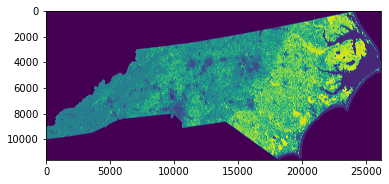

In [8]:
plt.imshow(lclu_data)

We have a map! However, NLCD data comes with specific colors that map to specific land cover types, and we can see the numerical representations of these colors as the values in our `lclu_colors` dictionary. The keys for this dictionary are the NLCD land cover types. 

Also, the map above does not have spatial x and y axes. We will add these shortly. 

If you look at your QGIS project, the NLCD raster loaded with specific colors. We will now plot the raster with these colors in Python.

<p align="center">
    <img src='imgs/QGIS_NCnlcd.PNG' width='650' /> 
</p>

<!-- **Note:** If we try to plot `lclu_data_rxr` we will run into a MemoryError. We will plot with `rioxarray` with a smaller array later. -->

In [9]:
lclu_colors

{0: (0, 0, 0, 255),
 1: (0, 0, 0, 255),
 2: (0, 0, 0, 255),
 3: (0, 0, 0, 255),
 4: (0, 0, 0, 255),
 5: (0, 0, 0, 255),
 6: (0, 0, 0, 255),
 7: (0, 0, 0, 255),
 8: (0, 0, 0, 255),
 9: (0, 0, 0, 255),
 10: (0, 0, 0, 255),
 11: (70, 107, 159, 255),
 12: (209, 222, 248, 255),
 13: (0, 0, 0, 255),
 14: (0, 0, 0, 255),
 15: (0, 0, 0, 255),
 16: (0, 0, 0, 255),
 17: (0, 0, 0, 255),
 18: (0, 0, 0, 255),
 19: (0, 0, 0, 255),
 20: (0, 0, 0, 255),
 21: (222, 197, 197, 255),
 22: (217, 146, 130, 255),
 23: (235, 0, 0, 255),
 24: (171, 0, 0, 255),
 25: (0, 0, 0, 255),
 26: (0, 0, 0, 255),
 27: (0, 0, 0, 255),
 28: (0, 0, 0, 255),
 29: (0, 0, 0, 255),
 30: (0, 0, 0, 255),
 31: (179, 172, 159, 255),
 32: (0, 0, 0, 255),
 33: (0, 0, 0, 255),
 34: (0, 0, 0, 255),
 35: (0, 0, 0, 255),
 36: (0, 0, 0, 255),
 37: (0, 0, 0, 255),
 38: (0, 0, 0, 255),
 39: (0, 0, 0, 255),
 40: (0, 0, 0, 255),
 41: (104, 171, 95, 255),
 42: (28, 95, 44, 255),
 43: (181, 197, 143, 255),
 44: (0, 0, 0, 255),
 45: (0, 0, 0, 255

Here is the legend provided by MRLC:

<img src='imgs/NLCD_Colour_Classification_Update.jpg' width='300' /> 

A detailed description of each land cover class can be found [here](https://www.mrlc.gov/data/legends/national-land-cover-database-class-legend-and-description) and in the NLCDclasses.pdf in the nlcd_2019_land_cover_l48 folder.

Now let's try getting our map's colors to match our given land cover colors and add a legend.

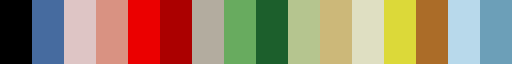

In [10]:
## This code is modified from the code found here: 
# https://makersportal.com/blog/2019/7/17/satellite-imagery-analysis-in-python-part-iii-land-surface-temperature-and-the-national-land-cover-database-nlcd

# we are importing a few more functions and modules
# if you are writing a script, it's best practice to have all of these import statements at the top
# however, because this is a tutorial, we have included them here
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# colormap determination and setting bounds
lclu_colors2 = [[float(jj)/255.0 for jj in lclu_colors[ii]] for ii in lclu_colors] 
nlcd_classes_nc = np.unique(lclu_data) # a list of the NLCD classes in our NC raster
r_cmap = []    
# for each NLCD class, we are appending its defined color in a new list
for ii in nlcd_classes_nc:
    r_cmap.append(lclu_colors2[ii])
raster_cmap = ListedColormap(r_cmap) # defining the NLCD specific color map
norm = mpl.colors.BoundaryNorm(nlcd_classes_nc-0.5, raster_cmap.N - 1) # specifying colors for values within a number range

# legend indices and strings that represent each NLCD land cover type
nlcd_classes = np.array([0,11,12,21,22,23,24,31,41,42,43,51,52,71,72,73,74,81,82,90,95])
nlcd_str = np.array(['NaN','Open Water','Perennial Ice/Snow','Developed, Open Space','Developed, Low Intensity',
           'Developed, Medium Intensity','Developed High Intensity','Barren Land (Rock/Sand/Clay)',
           'Deciduous Forest','Evergreen Forest','Mixed Forest','Dwarf Scrub','Shrub/Scrub',
           'Grassland/Herbaceous','Sedge/Herbaceous','Lichens','Moss','Pasture/Hay','Cultivated Crops',
           'Woody Wetlands','Emergent Herbaceous Wetlands'])

# look at the colormap we have created - this is specific for the NLCD classes in NC
raster_cmap

In [11]:
# we now want to creat our legend string for our NC NLCD classes

# first, we create a dictionary of the NLCD class numbers and names
nlcd_dict = dict(zip(nlcd_classes, nlcd_str))
print(nlcd_dict)
# then we get a list of the NLCD names based on our NLCD classes for NC
nc_nlcd_str = [nlcd_dict[i] for i in nlcd_classes_nc]
nc_nlcd_str

{0: 'NaN', 11: 'Open Water', 12: 'Perennial Ice/Snow', 21: 'Developed, Open Space', 22: 'Developed, Low Intensity', 23: 'Developed, Medium Intensity', 24: 'Developed High Intensity', 31: 'Barren Land (Rock/Sand/Clay)', 41: 'Deciduous Forest', 42: 'Evergreen Forest', 43: 'Mixed Forest', 51: 'Dwarf Scrub', 52: 'Shrub/Scrub', 71: 'Grassland/Herbaceous', 72: 'Sedge/Herbaceous', 73: 'Lichens', 74: 'Moss', 81: 'Pasture/Hay', 82: 'Cultivated Crops', 90: 'Woody Wetlands', 95: 'Emergent Herbaceous Wetlands'}


['NaN',
 'Open Water',
 'Developed, Open Space',
 'Developed, Low Intensity',
 'Developed, Medium Intensity',
 'Developed High Intensity',
 'Barren Land (Rock/Sand/Clay)',
 'Deciduous Forest',
 'Evergreen Forest',
 'Mixed Forest',
 'Shrub/Scrub',
 'Grassland/Herbaceous',
 'Pasture/Hay',
 'Cultivated Crops',
 'Woody Wetlands',
 'Emergent Herbaceous Wetlands']

In [12]:
# we now need to create our legend patches (the squares of color linked with our legend string)
import matplotlib.patches as mpatches

# create a patch for each color
patches = [ mpatches.Patch(color=r_cmap[i], label="{l}".format(l=nc_nlcd_str[i]) ) for i in range(len(nc_nlcd_str)) ]

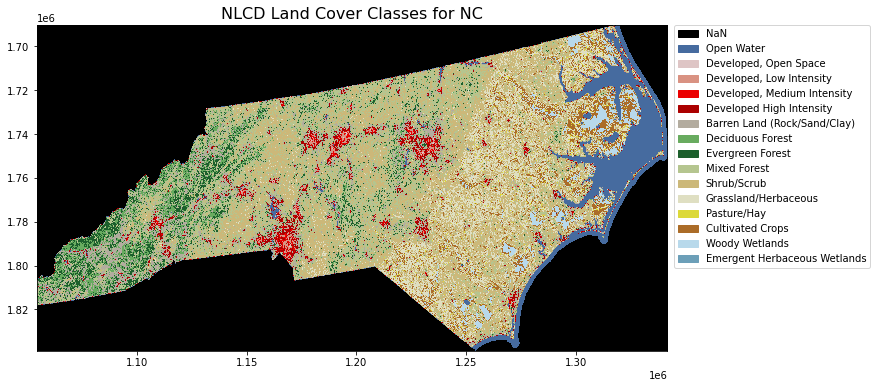

In [13]:
# finally, plot!
plt.figure(figsize=(16,6)) # set the figure size (width, height)
plt.imshow(lclu_data, cmap=raster_cmap, norm=norm, extent=lclu_extent) # plot the raster, the extent argument adds the spatial bounds
# with our new color map (cmap and norm are needed)
# also, adding extent puts the spatial values on the x and y axes (this is in meters, so it's not lat and lon)
plt.legend(handles=patches, bbox_to_anchor=(1.01,1), loc=2, borderaxespad=0.) # add our legend
plt.title("NLCD Land Cover Classes for NC", size=16) # add a title and adjust the title font size
plt.show()

### Visualizing Raster Histograms in Python

Another way we can assess our raster image is to look at the distribution of pixel values. 

We will first want to look at our maximum and minimum pixel values. Additionally, because we know that the NLCD dataset is a **classified** raster - that is, a raster where pixel values indicate a specific class, like "Evergreen Forest" - we can explore the unique values of this image.

In [14]:
print(f'LCLU max value: {lclu_data.max()}')
print(f'LCLU min value: {lclu_data.min()}')
print(f'LCLU unique values: {np.unique(lclu_data)}')

LCLU max value: 95
LCLU min value: 0
LCLU unique values: [ 0 11 21 22 23 24 31 41 42 43 52 71 81 82 90 95]


Next, we can make a histogram of the pixel values in order to visualize the range and distribution of our classes.

The `.flatten()` function on a `numpy array` changes the array from 2-D array to a 1-D array, which works better with the `.hist()` function in `matplotlib.pyplot`.

Text(0, 0.5, 'Count')

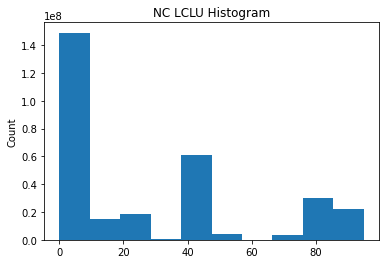

In [20]:
plt.hist(lclu_data.flatten()) 
plt.title("NC LCLU Histogram")
plt.ylabel("Count")

Great! However, this histogram does not tell us about the distribution of individual classes. For example, classes 21-24 appear to all be grouped together in one bin of our histogram.

One way we can adjust this is to set the bins so they are individual for each class. The `plt.hist()` function takes the argument `bins` as a list where the bin ranges from one number to the next, excluding the latter (e.g. `bins=[0,11,21]` will produce two bars, one with the count of values ranging from 0 to 10 and the second ranging from 11 to 20).

Text(0.5, 0, 'LCLU Class')

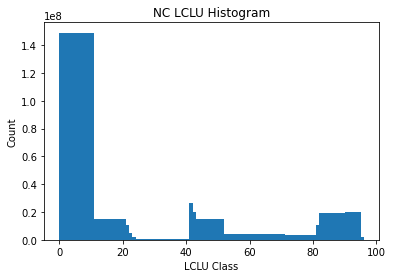

In [21]:
# try plotting the histogram with bars for each class
plt.hist(lclu_data.flatten(), bins=[0, 11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95, 96])
plt.title("NC LCLU Histogram")
plt.ylabel("Count")
plt.xlabel("LCLU Class")

One problem with this histogram is that now are bars are all of different widths. This time, let's try setting the number of bins to 100.

Text(0.5, 0, 'LCLU Class')

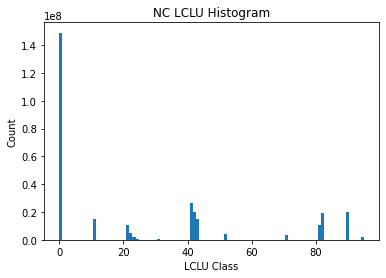

In [23]:
# try plotting the histogram with bars for each class
plt.hist(lclu_data.flatten(), bins=100)
plt.title("NC LCLU Histogram")
plt.ylabel("Count")
plt.xlabel("LCLU Class")

Great! Now we are visualizing the frequency of each individual class. Which class has the most number of pixels, aside from 0? What land cover type is that?

There is another way to view a raster histogram using a built-in function in `rasterio`. Again, let's set our number of bins to 100.

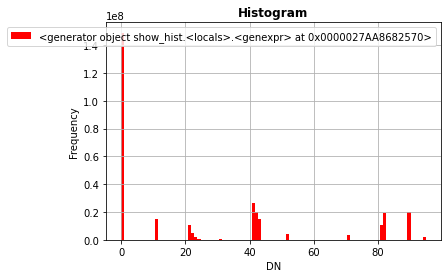

In [24]:
# another way to get a histogram
from rasterio.plot import show_hist

src = rio.open(nc_lclu_path)

show_hist(src,
    bins=100, lw=0.0, stacked=False, alpha=1,
    histtype='stepfilled', title="Histogram")

# if you read in src without a WITH statement, you MUST close it
src.close()

### Visualize Raster Histograms in QGIS

We can also view a histogram of pixel values in QGIS. 

Again, right click on the raster layer in the "Layer" window on the left. Then click on the "Histogram" tab on the left of the "Layer Properties" window that opens. Click "Compute Histogram".

<p align="center">
    <img src='imgs/QGIS_rasterHist.PNG' width='800' /> 
</p>

How does this compare with our histograms above?

#### Continuous Raster Data

So far, we've been working with a classified raster. The NLCD data had pixel values that were associated with specific land cover classes. Another type of raster data is continuous data. 

"Continuous data, or a continuous surface, represents phenomena where each location on the surface is a measure of the concentration level or its relationship from a fixed point in space or from an emitting source. Continuous data is also referred to as field, nondiscrete, or surface data. One type of continuous surface data is derived from those characteristics that define a surface where each location is measured from a fixed registration point. These include elevation (the fixed point being sea level) and aspect (the fixed point being direction: north, east, south, and west)" ([ESRI, 2021](https://desktop.arcgis.com/en/arcmap/latest/extensions/3d-analyst/discrete-and-continuous-data-in-3d-analyst.htm)).

Continuous data typically do not have well-defined boundaries between possible values.

One way to think of continuous data is to think of the gradual slope of a hill or an Appalachain mountain, while discrete data would be like a set of stairs or a terraced farm.

<p align="center">
    <img src='imgs/continuous_discrete.PNG' width='1000' /> 
</p>

We'll read in a Digital Elevation Model (DEM). 

In [25]:
# read in raster 

with rio.open(nc_dem_path) as src:
    dem_data = src.read(1)
    
    # get metadata
    dem_meta = src.meta
    for key in dem_meta.keys():
        print(f'{key}: {dem_meta[key]}')
    # save metadata of interest by specifically calling the src attributes
    dem_crs = src.crs
    dem_res = src.res
    dem_extent = src.bounds
    dem_bands = src.count
    dem_noData = src.nodatavals

print(f'\nDEM resolution: {dem_res}')
print(f'DEM extent: {dem_extent}')
print(f'DEM no data values: {dem_noData}')


driver: GTiff
dtype: int16
nodata: -32767.0
width: 32118
height: 10206
count: 1
crs: EPSG:4326
transform: | 0.00, 0.00,-84.32|
| 0.00,-0.00, 36.59|
| 0.00, 0.00, 1.00|

DEM resolution: (0.0002777777777777782, 0.00027777777777777854)
DEM extent: BoundingBox(left=-84.32180555555556, bottom=33.75291666666666, right=-75.40013888888888, top=36.587916666666665)
DEM no data values: (-32767.0,)


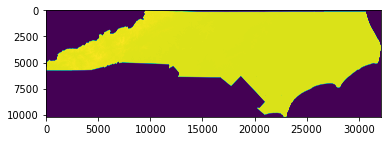

In [26]:
plt.imshow(dem_data)

In [ ]:
# view dataframe
dem_data

In [ ]:
# get min and max values
print(f'DEM max value: {dem_data.max()}')
print(f'DEM min value: {dem_data.min()}')


In [ ]:
plt.hist(dem_data.flatten())
plt.title("NC DEM Histogram")
plt.ylabel("Count")

What does this histogram tell us about our DEM? Why do you think we only have these two bars?

Let's try to mask our raster data to ignore our no data values.

In [ ]:
# read in raster 
with rio.open(nc_dem_path) as src:
    dem_data = src.read(1, masked=True)
    
    # get metadata
    dem_meta = src.meta
    # save metadata of interest by specifically calling the src attributes
    dem_crs = src.crs
    dem_res = src.res
    dem_extent = src.bounds
    dem_bands = src.count
    dem_noData = src.nodatavals

print(f'\nDEM resolution: {dem_res}')
print(f'DEM extent: {dem_extent}')
print(f'DEM no data values: {dem_noData}')

# get min and max values
print(f'\nDEM max value: {dem_data.max()}')
print(f'DEM min value: {dem_data.min()}')

dem_data


In [ ]:
plt.hist(dem_data.flatten())
plt.title("NC DEM Histogram")
plt.ylabel("Count")

In [ ]:
from rasterio.plot import show

src = rio.open(nc_dem_path)
nc_dem_data = src.read(1, masked=True)

dem_transform = src.transform

fig, ax = plt.subplots(figsize=(18,6))
img = show(nc_dem_data, transform=src.transform, ax=ax)
fig.colorbar(img.get_images()[0], ax=ax)
ax.set_title("SRTM Elevation for NC", fontsize=16)
plt.show()

src.close()

In [ ]:
dem_data_rxr = rxr.open_rasterio(nc_dem_path, masked=True)
dem_data_rxr.plot()
plt.show()

## Plot Raster and Vector Data



`rioxarray` is a package that expands the `xarray` package and capabilities with the spatial raster reading, processing, and analyzing capabilities of `rasterio`. When you open a raster using `rioxarray`, the pixel data is stored in an `xarray.DataArray` which uses `numpy` arrays and is very efficient. 

In [ ]:
# read in county shapefile
us_counties = gpd.read_file('./data/tl_2021_us_county/tl_2021_us_county.shp')
us_counties.head()

In [ ]:
wake_county = us_counties[(us_counties['STATEFP']=='37') & (us_counties['NAME']=='Wake')]
wake_county

In [ ]:
print(f'County SHP CRS: {wake_county.crs}')
print(f'NLCD CRS: {lclu_crs}')
print(f'DEM CRS: {dem_crs}')


### Reproject raster with rasterio

In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
# width: 26158
# height: 11613
#calculate transform array and shape of reprojected raster
transform, width, height = calculate_default_transform(
        lclu_crs, wake_county.crs, 26158, 11613, *lclu_extent)

print("transform array of source raster")
print(lclu_meta['transform'])

print("transform array of destination raster")
print(transform)

In [ ]:
#working of the meta for the destination raster
kwargs = lclu_meta.copy()
kwargs.update({
        'crs': wake_county.crs,
        'transform': transform,
        'width': 26158,
        'height': 11613
    })
#open destination raster
dstRst = rio.open('./data/output/NC_NLCD_reproj.tif', 'w', **kwargs)
#reproject and save raster band data
reproject(
    source=lclu_data,
    destination=rio.band(dstRst, 1),
    src_transform=lclu_transform,
    src_crs=lclu_crs,
    dst_transform=wake_county.transform,
    dst_crs=wake_county.crs,
    resampling=Resampling.nearest)
#close destination raster
dstRst.close()

In [ ]:
from rasterio.plot import show
# read in our new raster 
src= rio.open('./data/output/NC_NLCD_reproj.tif') 
lclu_data = src.read(1) # use 1 because rasters index starting at 1

lclu_crs = src.crs
lclu_res = src.res
lclu_extent = src.bounds
lclu_bands = src.count
lclu_transform = src.transform

fig, ax = plt.subplots(figsize=(20,6))
img = show(lclu_data, transform=src.transform, ax=ax, cmap=raster_cmap, norm=norm)
# fig.colorbar(img.get_images()[0], ax=ax)
# ax.set_title("SRTM Elevation for NC", fontsize=16)
# plt.show()

# fig, ax = plt.subplots(figsize=(16,6))
# src.show(cmap=raster_cmap, norm=norm, ax=ax) # plot the raster
ax.legend(handles=patches, bbox_to_anchor=(1.01,1), loc=2, borderaxespad=0.) # add our legend
ax.set_title("NLCD Land Cover Classes for NC", fontsize=16) # add a title and adjust the title font size
wake_county.plot(ax=ax, edgecolor='black', facecolor='none', markersize=10)
plt.show()

src.close()

In [ ]:
## DEM

# from rasterio.warp import calculate_default_transform, reproject, Resampling
# width: 32118
# height: 10206
#calculate transform array and shape of reprojected raster
transform, width, height = calculate_default_transform(
        dem_crs, wake_county.crs, 32118, 10206, *dem_extent)

print("transform array of source raster")
print(dem_meta['transform'])

print("transform array of destination raster")
print(transform)

In [ ]:
#working of the meta for the destination raster
kwargs = dem_meta.copy()
kwargs.update({
        'crs': wake_county.crs,
        'transform': transform,
        'width': 26158,
        'height': 11613
    })
#open destination raster
dstRst = rio.open('./data/output/NC_DEM_reproj.tif', 'w', **kwargs)
#reproject and save raster band data
reproject(
    source=dem_data,
    destination=rio.band(dstRst, 1),
    src_transform=dem_transform,
    src_crs=dem_crs,
    dst_transform=wake_county.transform,
    dst_crs=wake_county.crs,
    resampling=Resampling.nearest)
#close destination raster
dstRst.close()

In [ ]:
# read in our new raster 
src= rio.open('./data/output/NC_DEM_reproj.tif') 
dem_data = src.read(1, masked=True) # use 1 because rasters index starting at 1
# show(dem_data)

dem_crs = src.crs
dem_res = src.res
dem_extent = src.bounds
dem_bands = src.count
dem_transform = src.transform

fig, ax = plt.subplots(figsize=(20,6))
img = show(dem_data, transform=src.transform, ax=ax)
fig.colorbar(img.get_images()[0], ax=ax)
ax.set_title("SRTM Elevation for NC", fontsize=16)
wake_county.plot(ax=ax, edgecolor='black', facecolor='none', markersize=10)
plt.show()

src.close()

### Clip Raster with Polygon

In [ ]:
import rioxarray as rxr

lclu_rxr = rxr.open_rasterio('./data/output/NC_NLCD_reproj.tif').squeeze()

lclu_clip = lclu_rxr.rio.clip(wake_county.geometry, wake_county.crs)

f, ax = plt.subplots(figsize=(16, 14))
lclu_clip.plot(ax=ax, cmap=raster_cmap, norm=norm, add_colorbar=False)
ax.set(title="Wake County NLCD")
# ax.set_axis_off()
ax.legend(handles=patches, bbox_to_anchor=(1.01,1), loc=2, borderaxespad=0.) # add our legend

plt.show()

In [ ]:
np.unique(lclu_clip)

In [ ]:
dem_rxr = rxr.open_rasterio('./data/output/NC_DEM_reproj.tif', masked=True).squeeze()

dem_clip = dem_rxr.rio.clip(wake_county.geometry, wake_county.crs)

f, ax = plt.subplots(figsize=(8, 6))
dem_clip.plot(ax=ax, add_colorbar=True, cmap='viridis')
ax.set(title="Wake County DEM")

plt.show()


We can also plot the raster data using `rioxarray` using the `xarray.plot()` function. As we see below, it automatically incorporates the spatial information.

In [ ]:
fig, ax = plt.subplots(figsize=(16,6)) # set the figure size (width, height)
lclu_data_rxr.plot(ax=ax)
